In [1]:
import numpy as np
from scipy.linalg import pinv, norm
#from tensorly import unfold, fold, kr
import timeit
import time
import matplotlib.pyplot as plt

# Códigos: algebra linear


In [2]:
def my_cholesky(a): 
    n = len(a)
    l = np.zeros(a.shape)
    for i in range(n):
        l[i, i] = np.sqrt(a[i, i] - l[i, :]@l[i, :].T)
        for j in range(i+1, n):  
            l[j, i] = (a[j, i] - l[i, :]@l[j, :].T)/l[i, i]        
    return l, l.T

def sub_prog(matrix, b):
    '''
      Implementando a subistituição progressiva para resolução de um sistema linear Ax=b, tendo
    como parâmetros a matriz triangular superior e o vetor b, retornando o vetor de icógnitas x.
    '''
    n = len(matrix)
    x = np.zeros(n)
    for i in range(n):
        soma = 0
        for j in range(n-1):
            soma += matrix[i, j]*x[j]
        x[i] = (b[i] - soma)/matrix[i, i]
    return x

def sub_reg(matrix,b):
    '''
      Implementando a subistituição regressiva para resolução de um sistema linear Ax=b, tendo
    como parâmetros a matriz triangular superior e o vetor b, retornando o vetor de icógnitas x.
    '''
    n = len(matrix)
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        soma = 0
        for j in range(i + 1, n):
            soma += matrix[i, j]*x[j]
        x[i] = (b[i] - soma)/matrix[i, i]
    return x

def my_lu(matrix):
    '''
      Implementando a decomposição LU de uma matriz passada como parâmetro via eleminação de Gauss.
    '''
    n = len(matrix)
    l = np.identity(n)    # Matriz para receber os multiplicadores -> matriz L
    
    # ---------------------------pivotação---------------------------------------
    for i in range(n - 1):
        if matrix[i, i] is 0:
            for j in range(i + 1, n):
                if matrix[j, i] is not 0:
                    auxm = np.copy(matrix[i, :])     # Variável auxiliar (auxm) para armazenar 
                    matrix[i, :] = matrix[j, :]      # a linha com pivô=0
                    matrix[j, :] = auxm
                    break
    # ---------------------------------------------------------------------------
    
    for j in range(n - 1):
        for i in range(j + 1, n):
            m = matrix[i, j]/matrix[j, j]            # Calcula o multiplicador
            l[i, j] = m
            matrix[i, :] -= m*matrix[j, :]           # Linha recebe linha - multiplicador*linha pivô
            
    return l, matrix


def my_qr(a):
    
    def householder(c, e):
        v = c + np.linalg.norm(c)*e
        return np.eye(len(a)) - 2*(np.outer(v, v)/np.dot(v, v))
    
    c = a[:,0]
    e = np.zeros(len(a))
    if c[0] >= 0:
        e[0] = 1
    else: 
        e[0] = -1
    
    q = householder(c, e)
    r = householder(c, e)@a
    
    for n in range(len(r)):
        for m in range(len(r)):
            if abs(r[n, m]) < 1e-10:
                r[n, m] = 0

    for i in range(1, len(a)-1):
        
        c = np.copy(r[:, i])
        for j in range(i):
            c[j] = 0
        
        e = np.zeros(len(a))
        if c[i] > 0:
            e[i] = 1
        else: 
            e[i] = -1
        
        h = householder(c, e)
        q = q@h
        r = h@r
        
        for n in range(len(r)):
            for m in range(len(r)):
                if abs(r[n, m]) < 1e-10:
                    r[n, m] = 0
    return q, r

# Códigos: tensores

In [3]:
# Como é o tensor no pyhton:
#np.random.rand(2,3,5,1)

## Implementando operação de unfolding

Unfolding(Matriciação) é uma operação que reordena os elementos de um tensor em uma matriz correspondente ao tipo de operação ou modo.

Para um tensor $\mathcal{X} \in \mathbb{R}^{I\;\times \;J\;\times \;K}$ de ordem 3 tem-se os seguintes modos:

$
\mathbf{X}_{(1)} \;\;(I\times JK)\\
\mathbf{X}_{(2)} \;\;(J\times IK)\\
\mathbf{X}_{(3)} \;\;(K\times IJ)
$

O processo de matriciação de $\mathcal{X}$ ordena as modo-n fibras do tensor como as colunas da matrix $\mathbf{X}_{(n)}$.

In [4]:
def my_unfold(tensor, mode):
    '''
    Função que executa a operação de unfolding de um tensor de 3ª Ordem.
    
    :param tensor: matriz i x k
    :param mode: modo desejado (1, 2 ou 3)
    :return : matriz do modo {(i x jk), (j, ik), (k, ij)}
    '''
    t = tensor.shape
    if mode is 1: # i, jk
        return np.transpose(tensor, (1,0,2)).reshape(t[mode], int(np.prod(t)/t[mode]))
    elif mode is 2: # j, ik
        return np.transpose(tensor, (2,0,1)).reshape(t[mode], int(np.prod(t)/t[mode]))
    elif mode is 3:# k, ij
        # shape 3 ordem = (i0, i1, i2)
        return np.transpose(tensor, (0,2,1)).reshape(t[0], int(np.prod(t)/t[0]))
    else:
        print("Modo não suportado")
        return None

In [5]:
# shape(k,i,j)
T = np.array([
              [[1,4,7,10],
               [2,5,8,11],
               [3,6,9,12]],
              
              [[13,16,19,22],
               [14,17,20,23],
               [15,18,21,24]]
             ])

tn1 = my_unfold(T, 1)

print('\n Tensor T:\n')
print(T, T.shape)
print('\n Unfold modo {}:\n\n'.format(1), tn1, tn1.shape)

tn2 = my_unfold(T, 2)
print('\n Unfold modo {}:\n\n'.format(2), tn2, tn2.shape)

tn3 = my_unfold(T, 3)
print('\n Unfold modo {}:\n\n'.format(3), tn3, tn3.shape)

print('\nDesempenho da função (timeit):\n')
%timeit my_unfold(T, 1)


 Tensor T:

[[[ 1  4  7 10]
  [ 2  5  8 11]
  [ 3  6  9 12]]

 [[13 16 19 22]
  [14 17 20 23]
  [15 18 21 24]]] (2, 3, 4)

 Unfold modo 1:

 [[ 1  4  7 10 13 16 19 22]
 [ 2  5  8 11 14 17 20 23]
 [ 3  6  9 12 15 18 21 24]] (3, 8)

 Unfold modo 2:

 [[ 1  2  3 13 14 15]
 [ 4  5  6 16 17 18]
 [ 7  8  9 19 20 21]
 [10 11 12 22 23 24]] (4, 6)

 Unfold modo 3:

 [[ 1  2  3  4  5  6  7  8  9 10 11 12]
 [13 14 15 16 17 18 19 20 21 22 23 24]] (2, 12)

Desempenho da função (timeit):

10.9 µs ± 639 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Implementando o Produto de Khatri-Rao


Dadas as matrizes:
$
\mathbf{A}^{i\times k} = 
\begin{bmatrix} 
    a_{00} & \cdots & a_{0k}\\
   \vdots  & \ddots & \vdots\\
    a_{i0} & \cdots & a_{ik}
\end{bmatrix}
$
$\;\;\;$
$
\mathbf{B}^{j\times k} = 
\begin{bmatrix} 
    b_{00} & \cdots & b_{0k}\\
   \vdots  & \ddots & \vdots\\
    b_{j0} & \cdots & b_{jk}
\end{bmatrix}
$

O produto de Khatri-Rao de A e B pode ser descrito por:

$$
\mathbf{A}⊙\mathbf{B}=[\mathbf{a}_1⊗\mathbf{b}_1\;\mathbf{a}_2⊗\mathbf{b}_2\cdots \mathbf{a}_k⊗\mathbf{b}_k]
$$

onde é feito um produto de Kronecker coluna a coluna.

Implementando o produto de Khatri-Rao $\mathbf{A}⊙\mathbf{B}$, tem-se em código:


```python
import numpy as np
C = np.einsum('ik,jk->ijk', A, B)
```

Onde a função Numpy.einsum() implementa a convençação de Einstein para o somatório como o exemplo abaixo para o produto matricial:

$$
\mathbf{C} = \mathbf{AB} = C_{ik} = \sum_{j=1}^{N} A_{ij} B_{jk} = A_{ij} B_{jk}
$$



<p align="center">
<img src="einsum.png" alt="einsum" width="500"/>
</p>

<p align="center">
<img src="einumMTX.png" alt="einumMTX" width="400"/>
</p>

Equivalentemente, a função Numpy.einsum() com o argumento ```'ik,jk,->ijk'```  executa o produto de Kronecker coluna a coluna entre as matrizes A e B, resultando em um tensor de 3ª ordem $\mathcal{C}$. A string ```'ik,jk,->ijk'``` representa os somatórios que compõem o produto como a estrutura abaixo:

```python
for k in range(K):
    for i in range(I):
        for j in range(J):
            C[i, j, k] = A[i, k] * B[j, k]
```
Para compor a matriz $\mathbf{C}$, resultado do produto de Khatri-Rao, é necessário o uso da função ndaray.reshape() de modo que reordene os elementos de $\mathcal{C}$ em uma matriz $(ij\times k)$
```python
C = np.einsum('ik,jk->ijk', A, B)
C = C.reshape(-1, K) # K colunas
```
A função para o produto de Khatri-Rao de duas matrizes é implementada abaixo:

In [6]:
def my_kr(mt_a, mt_b):
    '''
    Função que executa o produto de Khatri-Rao entre A e b.
    
    :param mt_a: matriz i x k
    :param mt_b: matriz j x k
    :return : matriz ij x k
    '''
    if mt_a.shape[1] is mt_b.shape[1]:
        ncol = mt_a.shape[1]
        return np.einsum('az,bz->abz', mt_a, mt_b).reshape((-1, ncol))
    else: 
        print('Erro: As matrizes precisam ter o mesmo número de colunas!\n')
        return None

### Exemplo

In [7]:
# Funcionamento do algorítimo:
# I,J,K = 2,2,2
# A = np.array([[1, 1],
#               [2, 2]])

# B = A
# C = np.zeros((I,J,K))

# for k in range(K):
#     for i in range(I):
#         for j in range(J):
#             C[i, j, k] = A[i, k] * B[j, k]
#             print(C.reshape(-1, K))

In [8]:
# Valor resultado via Tensorly.kr():
# array([[0.9115241 , 0.        ],
#        [0.        , 0.51736874]])

matrices = [np.eye(2,2), np.array([[0.9115241, 0.51736874]])]

print('A : \n',   matrices[0],   matrices[0].shape)
print('\nB : \n', matrices[1],   matrices[1].shape)
print('\nC = A⊙B : \n', my_kr(*matrices), my_kr(*matrices).shape )

print('\nDesempenho da função (timeit):\n')
%timeit my_kr(*matrices)

A : 
 [[1. 0.]
 [0. 1.]] (2, 2)

B : 
 [[0.9115241  0.51736874]] (1, 2)

C = A⊙B : 
 [[0.9115241  0.        ]
 [0.         0.51736874]] (2, 2)

Desempenho da função (timeit):

3.17 µs ± 226 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Implementação do Alternated Least Squares

### 1) Contrução de um tensor PARAFAC

O modelo PARAFAC para um tensor de 3ª ordem $\mathcal{X} \in \mathbb{R}^{I\;\times \;J\;\times \;K}$ é dado por:

$$
\mathcal{X} \approx [[\mathbf{A},\mathbf{B},\mathbf{C}]]
$$
onde $\mathbf{A} \in \mathbb{R}^{I\;\times \;R} $, $\mathbf{B} \in \mathbb{R}^{J\;\times \;R} $ e $\mathbf{C} \in \mathbb{R}^{K\;\times \;R} $ são as matrizes fatores que agrupam os tensores de rank-1 que compõem o tensor PARAFAC via:

$$
\mathcal{X} \approx \sum_{r=1}^{R} \mathbf{a}_r \circ \mathbf{b}_r \circ \mathbf{c}_r
$$ com $\mathcal{X}$ um tensor de rank $R$

A partir das matrizes fatores, é possível estimar as matrizes $\mathbf{X}_{(n)}$ do tensor $\mathcal{X}$ de modo que:

$$
\mathbf{X}_{(1)} \approx \mathbf{A}(\mathbf{C}⊙\mathbf{B})^T \\
\mathbf{X}_{(2)} \approx \mathbf{B}(\mathbf{C}⊙\mathbf{A})^T\\
\mathbf{X}_{(3)} \approx \mathbf{C}(\mathbf{B}⊙\mathbf{A})^T
$$

Para construção de $\mathcal{X}$ a partir de seus modos, a função abaixo foi implementada seguindo a ideia:

```octave
X = reshape(xn1, [I, J, K)] % Modo 1
```


In [9]:
def build_prfc(mt_a, mt_b, mt_c):
    '''
    Função que constrói um tensor de odem 3 a partir de suas matrizes fatores.
    '''
    i = mt_a.shape[0]
    j = mt_b.shape[0]
    k = mt_c.shape[0]
    
    # Construção de X(1):
    xn1 = mt_a@(my_kr(mt_c, mt_b).T)

    # Volta do unfold modo-1, notação python shape: (k, i, j)
    return np.moveaxis(np.reshape(xn1, (i, k, j)), 0, 1)

In [10]:
print('\nDesempenho da função (timeit):\n')
%timeit build_prfc(np.random.rand(2, 2), np.random.rand(2, 2), np.random.rand(2, 2))


Desempenho da função (timeit):

27.6 µs ± 4.83 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


###  2) Algorítimo ALS


In [11]:
def altr_ls(tensor, rank, itermax, eps):
    '''
    Função que executa a fatoração PARAFAC de um tensor via Alternated Least Squares.
    '''
    start = time.time()
    # python shape: (k, i, j)
    K, I, J = tensor.shape
    
    # Inicialização aleatória das matrizes fatores:
    mt_A = np.zeros((I, rank))
    mt_B = np.random.rand(J, rank)
    mt_C = np.random.rand(K, rank)
    
    # Extraindo modos do tensor:
    xn1 = my_unfold(tensor, 1)
    xn2 = my_unfold(tensor, 2)
    xn3 = my_unfold(tensor, 3)
    
    # ALS em função do erro eps:
    err = np.zeros(itermax)
    
    for i in range(itermax):
        mt_A = xn1@pinv(my_kr(mt_C, mt_B).T)
        mt_B = xn2@pinv(my_kr(mt_C, mt_A).T)
        mt_C = xn3@pinv(my_kr(mt_B, mt_A).T)
        
        xn1_als = mt_A@(my_kr(mt_C, mt_B).T)
        
        # Cálculo do erro quadrádico médio:
        #err[i] = (norm(xn1 - xn1_als, 'fro')**2)/(norm(xn1, 'fro')**2)
        err[i] = (np.sqrt(np.sum((xn1 - xn1_als)**2))**2)/np.sqrt(np.sum(xn1**2))**2
        
        if abs(err[i] - err[i - 1]) <= eps:
            iteractions = i + 1
            end = time.time()
            print('Algorítimo convergiu! \nTempo decorrido: {}s\n'\
                  'Diferença entre iterações: {}'\
                  .format(end - start, abs(err[i] - err[i - 1]))
                  )
            break
 
        elif i == itermax - 1:
            iteractions = i + 1
            print('Número máximo de iterações atingido!! \n'\
                  'Erro atual: {} \nDiferença entre iterações: {}'\
                  .format(err[i], abs(err[i] - err[i - 1]))
                  )
 
    return(mt_A, mt_B, mt_C, err, iteractions)

### 3) Constuindo tensor PARAFAC para o ALS


In [36]:
# Inicializando matrizes fatores em função do rank e das dimensões desejadas:
R = 2 # Rank; obs: menor ou igual ao min{IJ, IK, JK}, dúvida caso rank maior(poucas it) e igual(n converg+-)
I = 4
J = 4
K = 4

mt_a = np.random.randn(I, R)
mt_b = np.random.randn(J, R)
mt_c = np.random.randn(K, R)

# Construindo tensor de ordem 3:
X = build_prfc(mt_a, mt_b, mt_c)

print('Tensor X:\n\n {} {}\n'.format(X, X.shape))

Tensor X:

 [[[-1.41951381 -0.65958657 -0.16426062 -1.36157998]
  [-2.50968876 -1.59650584 -0.02899434 -1.87778289]
  [ 1.19373422  1.1104105  -0.19943798  0.46128948]
  [ 1.10528489  0.43861963  0.1734316   1.1523976 ]]

 [[-1.21675911 -1.42595371  0.38194688 -0.1083211 ]
  [-1.8016137  -1.91827059  0.44824583 -0.39794861]
  [ 0.57177589  0.42073912 -0.02802497  0.35766875]
  [ 1.00830544  1.21529262 -0.33694118  0.04838642]]

 [[-1.37648123 -1.4504031   0.3332345  -0.32275291]
  [-2.10421856 -2.06611317  0.4176245  -0.67930185]
  [ 0.73220068  0.57639246 -0.05873084  0.4117546 ]
  [ 1.1291495   1.21610826 -0.28934495  0.23237823]]

 [[ 0.91834223 -0.52413737  0.68384732  2.05070507]
  [ 2.00990085  0.42537301  0.54148342  2.55353522]
  [-1.27108503 -1.30514536  0.28694385 -0.3401183 ]
  [-0.64777431  0.64360462 -0.6487394  -1.78348539]]] (4, 4, 4)



### 4) Decomposição

Algorítimo convergiu! 
Tempo decorrido: 0.19844889640808105s
Diferença entre iterações: 8.72931719327874e-11


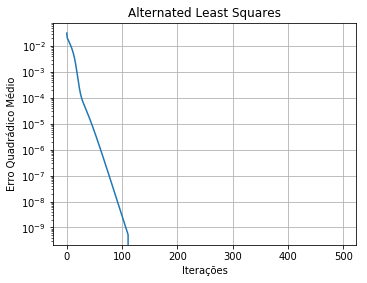



Número de iterações: 112
Erro Quadrádico Médio: 5.251614823263362e-10

Tensor X:

 [[[-2.73348697 -3.70649057 -2.99143525  2.41059197]
  [-1.48257552 -1.91551746 -1.5909565   1.19270664]
  [ 0.74049296 -0.25461491  0.39177935  0.87054527]
  [ 0.05842478 -0.22608684 -0.03759537  0.31803325]]

 [[ 1.12566001  1.51844169  1.22925524 -0.98312241]
  [ 0.54578844  0.739734    0.59718204 -0.48091541]
  [ 0.55473954  0.70181756  0.59033192 -0.42822225]
  [ 0.18446386  0.23755312  0.19769005 -0.14745641]]

 [[-0.8685929  -1.16863253 -0.94751828  0.75492394]
  [-0.3962285  -0.55190942 -0.43848791  0.36714532]
  [-0.75893165 -0.77130755 -0.74482454  0.35726663]
  [-0.22259564 -0.23889981 -0.22267298  0.12012822]]

 [[-0.87203415 -1.18575711 -0.95542743  0.77303878]
  [-0.50013137 -0.63167871 -0.53187007  0.38479445]
  [ 0.59690012  0.16922411  0.44033973  0.24846656]
  [ 0.10612248 -0.01152358  0.06444993  0.09454078]]] (4, 4, 4)

Tensor X estimado:

 [[[-2.73347202 -3.70649355 -2.99142662  2.4

In [13]:
mt_Ahat, mt_Bhat, mt_Chat, vt_eqm, it = altr_ls(X, R, 500, 1e-10)

# Recuperando tensor:
X_als = build_prfc(mt_Ahat, mt_Bhat, mt_Chat)

# Resultados:
dim = 0.85*6.4
plt.figure(figsize=[dim, 0.75*dim])
plt.grid()
plt.title('Alternated Least Squares')
plt.xlabel('Iterações')
plt.ylabel('Erro Quadrádico Médio')
plt.semilogy(vt_eqm,'-')
plt.show()

print('\n')
print('Número de iterações: {}'.format(it))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqm[it - 1]))

print('Tensor X:\n\n {} {}\n'.format(X, X.shape))
print('Tensor X estimado:\n\n {} {}\n'.format(X_als, X_als.shape))

## Implementação do Alternated Least Squares - Caso AWGN



Cenário com ruído aditivo gaussiano branco (AWGN) modelado por:

$$
\mathcal{Y} = \mathcal{X} + \sigma \mathcal{N};\; \;\; \mathcal{X},\;\mathcal{Y},\;\mathcal{N} \in \mathbb{R}^{I\;\times \;J\;\times \;K}
$$

onde $\mathcal{X}$ é o tensor que sofre os efeitos do canal AWGN representado por $\sigma \mathcal{N}$.

Neste modelo, $\sigma$ representa o desvio padrão (relacionado à potência) do ruído.

Como parâmetro de controle do efeito do canal, é definida a relação sinal-ruído (SNR):

$$
SNR = \frac{||\mathcal{X}||_{F}^{2}}{\sigma || \mathcal{N}||_{F}^{2}}
$$

correspondendo a razão da potencia do tensor $\mathcal{X}$ pelo tensor de ruído. O cenário em questão é implementado nas células abaixo:

### 1)  Modelando o cenário

In [14]:
def awgn(tensor, snr_db):
    '''
      Função que aplica o tensor de entrada a um canal com ruido aditivo gaussiano branco, considerando
    uma determinada SNR.
    '''
    # SNR:
    snr = 10**(snr_db*0.1) # [lin]
    
    K, I, J = tensor.shape
    tensor_ruido = np.random.randn(K, I, J)
    
    # Cálculo do desvio padão em função da SNR e tensor de ruído:
    sigma = 1/snr * (np.sqrt(np.sum(tensor**2))**2)/np.sqrt(np.sum(tensor_ruido**2))**2
    
    # Modelo:
    return tensor + tensor_ruido*(sigma)

In [15]:
# A partir de X gerado anteriormente...

Y0 = awgn(X, 20) # Casos variando a SNR: 10, 20 e 30 dB
Y1 = awgn(X, 30)
Y2 = awgn(X, 10)

### 2) Decomposição - AWGN

In [16]:
def altr_ls_awgn(tensor, tensor_ref, rank, itermax, eps):
    '''
      Função que executa a fatoração PARAFAC de um tensor via Alternated Least Squares,
      estimando o tensor após um canal AWGN.
    '''
    start = time.time()
    # python shape: (k, i, j)
    K, I, J = tensor.shape

    # Inicialização aleatória das matrizes fatores:
    mt_A = np.zeros((I, rank))
    mt_B = np.random.rand(J, rank)
    mt_C = np.random.rand(K, rank)

    # Extraindo modos do tensor: Y
    xn1 = my_unfold(tensor, 1)
    xn2 = my_unfold(tensor, 2)
    xn3 = my_unfold(tensor, 3)

    # Referência: X conhecido modo-1
    refn1 = my_unfold(tensor_ref, 1)

    # ALS em função do erro eps:
    err = np.zeros(itermax)
    
    for i in range(itermax):
        mt_A = xn1@pinv(my_kr(mt_C, mt_B).T)
        mt_B = xn2@pinv(my_kr(mt_C, mt_A).T)
        mt_C = xn3@pinv(my_kr(mt_B, mt_A).T)

        xn1_als = mt_A@(my_kr(mt_C, mt_B).T)

        # Cálculo do erro quadrádico médio:
        err[i] = (np.sqrt(np.sum((refn1 - xn1_als)**2))**2)/\
                  np.sqrt(np.sum((refn1)**2))**2

        if abs(err[i] - err[i - 1]) <= eps:
            iteractions = i + 1
            end = time.time()
            print('Algorítimo convergiu! \nTempo decorrido: {}s\n'\
                  'Diferença entre iterações: {}'\
                  .format((end - start), abs(err[i] - err[i - 1]))
                  )
            break
            
        elif i == itermax - 1:
            iteractions = i + 1
            print('Número máximo de iterações atingido!! \n'\
                  'Erro atual: {} \nDiferença entre iterações: {}'\
                  .format(err[i], abs(err[i] - err[i - 1]))
                  )
            
    return mt_A, mt_B, mt_C, err, iteractions

Caso SNR 20dB:

Algorítimo convergiu! 
Tempo decorrido: 0.10104036331176758s
Diferença entre iterações: 9.482791780274485e-11
Número de iterações: 115
Erro Quadrádico Médio: 3.898421628885024e-05



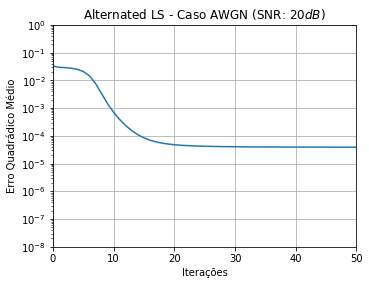

In [17]:
itrmax = 1000
tol = 1e-10

print('Caso SNR 20dB:\n')
mt_Ar0, mt_Br0, mt_Cr0, vt_eqm0, it0 = altr_ls_awgn(Y0, X, R, itrmax, tol)

print('Número de iterações: {}'.format(it0))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqm0[it0 - 1]))

# Recuperando tensor:
# Y0_als = build_prfc(mt_Ar0, mt_Br0, mt_Cr0)

# Resultados:
dim = 0.85*6.4
plt.figure(figsize=[dim, 0.75*dim])
plt.grid()
plt.title('Alternated LS - Caso AWGN (SNR: {}$dB$)'.format(20))
plt.xlabel('Iterações')
plt.ylabel('Erro Quadrádico Médio')
plt.semilogy(vt_eqm0, '-')
plt.axis([0, 50, 1e-8, 1e-0])
plt.show()


In [18]:
print('Caso SNR 30dB:\n')
mt_Ar1, mt_Br1, mt_Cr1, vt_eqm1, it1 = altr_ls_awgn(Y1, X, R, itrmax, tol)

print('Número de iterações: {}'.format(it1))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqm1[it1 - 1]))

print('\nCaso SNR 10dB:\n')
mt_Ar2, mt_Br2, mt_Cr2, vt_eqm2, it2 = altr_ls_awgn(Y2, X, R, itrmax, tol)

print('Número de iterações: {}'.format(it2))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqm0[it2 - 1]))

Caso SNR 30dB:

Algorítimo convergiu! 
Tempo decorrido: 0.07587766647338867s
Diferença entre iterações: 9.062454715552693e-11
Número de iterações: 106
Erro Quadrádico Médio: 5.681580291284517e-07


Caso SNR 10dB:

Algorítimo convergiu! 
Tempo decorrido: 0.4779047966003418s
Diferença entre iterações: 9.834354901608333e-11
Número de iterações: 724
Erro Quadrádico Médio: 0.0



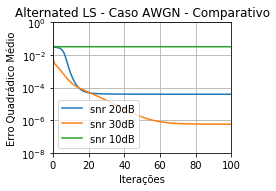

In [24]:
# Resultados:
dim = .5*6.4
plt.figure(figsize=[dim, 0.75*dim])
plt.grid()
plt.title('Alternated LS - Caso AWGN - Comparativo')
plt.xlabel('Iterações')
plt.ylabel('Erro Quadrádico Médio')
plt.semilogy(vt_eqm0, '-', label='snr 20dB')
plt.semilogy(vt_eqm1, '-', label='snr 30dB')
plt.semilogy(vt_eqm2, '-', label='snr 10dB')
plt.legend()
plt.axis([0, 100, 1e-8, 1e-0])
plt.show()

### 3) Alternated Least Squares - AWGN - Simulação de Monte Carlo

Gerendo curva do erro quadrádico médio com relação à diferentes SNRs.

In [20]:
def monte_carlo_als2(snr, tensor, rank, itermax, eps, trials):
    '''
    Função que performa a simulação de Monte Carlo para ALS caso AWGN, variando a SNR.
    '''
    # Função auxiliar - ALS:
    def als(tensor, tensor_ref, rank, itermax, eps):

        K, I, J = tensor.shape

        # Inicialização aleatória das matrizes fatores:
        mt_A = np.zeros((I, rank))
        mt_B = np.random.rand(J, rank)
        mt_C = np.random.rand(K, rank)

        # Extraindo modos do tensor: Y
        xn1 = my_unfold(tensor, 1)
        xn2 = my_unfold(tensor, 2)
        xn3 = my_unfold(tensor, 3)

        # Referência: X conhecido modo-1
        refn1 = my_unfold(tensor_ref, 1)

        # ALS em função do erro eps:
        err = np.zeros(itermax)

        for i in range(itermax):
            mt_A = xn1@pinv(my_kr(mt_C, mt_B).T)
            mt_B = xn2@pinv(my_kr(mt_C, mt_A).T)
            mt_C = xn3@pinv(my_kr(mt_B, mt_A).T)

            xn1_als = mt_A@(my_kr(mt_C, mt_B).T)

            # Cálculo do erro quadrádico médio:
            err[i] = (np.sqrt(np.sum((refn1 - xn1_als)**2))**2)/\
                      np.sqrt(np.sum((refn1)**2))**2

            if abs(err[i] - err[i - 1]) <= eps:
                eqm = err[i]
                # Remoção do break para obter o dado apenas na última iteração!
                break

            elif i == itermax - 1:
                eqm = err[i]

        return eqm

    # Monte Carlo:
    vt_eqmMed = np.zeros(trials)
        
    for i in range(trials):
        Y = awgn(tensor, snr)
        erro_atual = als(Y, tensor, rank, itermax, eps)

        # Armazena o erro quadrádico médio da rodada atual:
        vt_eqmMed[i] = erro_atual

    # Retornando valor médio para a snr especificada:
    return np.mean(vt_eqmMed)

In [21]:
# Simulação:

# Valores de SNR [dB]:
vt_snr = np.linspace(0, 40, 9) # 0 - 40, passo: 10

# Parâmetros: MUDAR ITERAÇÕES E ETC... EPS ALTO
trials = 10 # Iterações do Monte Carlo.
itrmax = 1000 # Iterações para o ALS.
tol = 1e-15    # Tolerância para a convergência o ALS.

print('Iniciando simulação de Monte Carlo para o ALS - AWGN:\n\n'\
      'Valores de SNR: {}\n'\
      'Número de iterações (ALS): {}\n'\
      'Tolerância (ALS): {}\n'\
      'Número de iterações (MC): {}\n'
      '\n..... \n'.format(vt_snr, itrmax, tol, trials)
     )

start = time.time()

vt_eqmMC = np.array([monte_carlo_als(snr, X, R, itrmax, tol, trials) for snr in vt_snr])

end = time.time()

dt = end - start

print('Simulação comcluída com sucesso! Tempo decorrido: {}min {}s'.format(int(dt/60), dt%60))

Iniciando simulação de Monte Carlo para o ALS - AWGN:

Valores de SNR: [ 0.  5. 10. 15. 20. 25. 30. 35. 40.]
Número de iterações (ALS): 1000
Tolerância (ALS): 1e-15
Número de iterações (MC): 10

..... 

Simulação comcluída com sucesso! Tempo decorrido: 0min 25.265364408493042s


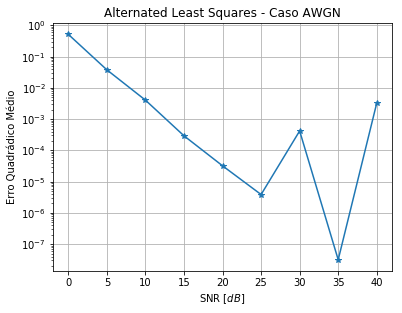

In [22]:
# Resultados:

dim = 0.95*6.4
plt.figure(figsize=[dim, 0.75*dim])
plt.grid()
plt.title('Alternated Least Squares - Caso AWGN')
plt.xlabel('SNR [$dB$]')
plt.ylabel('Erro Quadrádico Médio')
plt.semilogy(vt_snr, vt_eqmMC, '*-')
plt.show()


# dim = 0.95*6.4
# plt.figure(figsize=[dim, 0.75*dim])
# plt.grid()
# plt.xlabel('SNR [$dB$]')
# plt.ylabel('Erro Quadrádico Médio')
# plt.semilogy(vt_eqm0, '-', label='snr 20dB')
# plt.semilogy(vt_eqm1, '-', label='snr 30dB')
# plt.semilogy(vt_eqm2, '-', label='snr 10dB')
# plt.show()

## Alternated Least Squares - AWGN - Matrizes fatores conhecidas

Tratando o problema 4.

In [23]:
def altr_ls_awgn2(tensor, tensor_ref, rank, itermax, eps, mt1=None, mt2=None):
    '''
      Função que executa a fatoração PARAFAC de um tensor via Alternated Least Squares, estimando 
    o tensor após um canal AWGN com o conhecimento das matrizes fatores.
    '''
    start = time.time()
    # python shape: (k, i, j)
    K, I, J = tensor.shape

    # Inicialização das matrizes fatores:
    mt_A = np.zeros((I, rank))
    
    if mt1 is None:
        mt_B = np.random.rand(J, rank)
    else:
        mt_B = mt1

    if mt2 is None:
        mt_C = np.random.rand(K, rank)
    else:
        mt_C = mt2

    # Extraindo modos do tensor: Y
    xn1 = my_unfold(tensor, 1)
    xn2 = my_unfold(tensor, 2)
    xn3 = my_unfold(tensor, 3)

    # Referência: X conhecido modo-1
    refn1 = my_unfold(tensor_ref, 1)

    # ALS em função do erro eps:
    err = np.zeros(itermax)
    
    for i in range(itermax):
        mt_A = xn1@pinv(my_kr(mt_C, mt_B).T)
        mt_B = xn2@pinv(my_kr(mt_C, mt_A).T)
        mt_C = xn3@pinv(my_kr(mt_B, mt_A).T)

        xn1_als = mt_A@(my_kr(mt_C, mt_B).T)

        # Cálculo do erro quadrádico médio:
        err[i] = (np.sqrt(np.sum((refn1 - xn1_als)**2))**2)/\
                  np.sqrt(np.sum((refn1)**2))**2

        if abs(err[i] - err[i - 1]) <= eps:
            iteractions = i + 1
            end = time.time()
            print('Algorítimo convergiu! \nTempo decorrido: {}s\n'\
                  'Diferença entre iterações: {}'\
                  .format((end - start), abs(err[i] - err[i - 1]))
                  )
            break
            
        elif i == itermax - 1:
            iteractions = i + 1
            print('Número máximo de iterações atingido!! \n'\
                  'Erro atual: {} \nDiferença entre iterações: {}'\
                  .format(err[i], abs(err[i] - err[i - 1]))
                  )
            
    return mt_A, mt_B, mt_C, err, iteractions

## Modelo do cenário e decomposição

Caso SNR 20dB - mt_b Conhecida:

Algorítimo convergiu! 
Tempo decorrido: 0.03183937072753906s
Diferença entre iterações: 9.879595971537953e-08
Número de iterações: 47
Erro Quadrádico Médio: 3.3793936602196095e-05

Caso SNR 30dB - mt_b Conhecida:

Algorítimo convergiu! 
Tempo decorrido: 0.06038522720336914s
Diferença entre iterações: 9.325949542876019e-08
Número de iterações: 77
Erro Quadrádico Médio: 1.0085195723448496e-06

Caso SNR 10dB - mt_b Conhecida:

Algorítimo convergiu! 
Tempo decorrido: 0.03728771209716797s
Diferença entre iterações: 9.435811155773105e-08
Número de iterações: 59
Erro Quadrádico Médio: 0.0062338373577976855



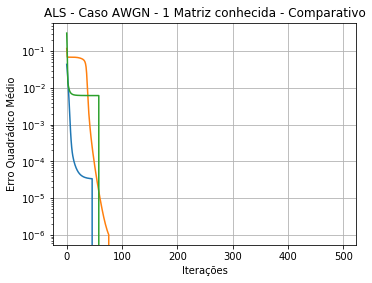

In [37]:
# Simulação para SNR's diferentes (1 Matriz conhecida):

Z0 = awgn(X, 20)
Z1 = awgn(X, 30)
Z2 = awgn(X, 10)

itrmax = 500
tol = 1e-7

# 20
print('Caso SNR 20dB - mt_b Conhecida:\n')
mt_Az0, mt_Bz0, mt_Cz0, vt_eqmz0, itz0 = altr_ls_awgn2(Z0, X, R, itrmax, tol, mt_b)
print('Número de iterações: {}'.format(itz0))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqmz0[itz0 - 1]))


# 30
print('Caso SNR 30dB - mt_b Conhecida:\n')
mt_Az1, mt_Bz1, mt_Cz1, vt_eqmz1, itz1 = altr_ls_awgn2(Z1, X, R, itrmax, tol, mt_b)
print('Número de iterações: {}'.format(itz1))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqmz1[itz1 - 1]))


# 10
print('Caso SNR 10dB - mt_b Conhecida:\n')
mt_Az2, mt_Bz2, mt_Cz2, vt_eqmz2, itz2 = altr_ls_awgn2(Z2, X, R, itrmax, tol, mt_b)
print('Número de iterações: {}'.format(itz2))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqmz2[itz2 - 1]))


# Resultados:
dim = 0.85*6.4
plt.figure(figsize=[dim, 0.75*dim])
plt.grid()
plt.title('ALS - Caso AWGN - 1 Matriz conhecida - Comparativo')
plt.xlabel('Iterações')
plt.ylabel('Erro Quadrádico Médio')

plt.semilogy(vt_eqmz0, '-', label='snr 20dB')
plt.semilogy(vt_eqmz1, '-', label='snr 30dB')
plt.semilogy(vt_eqmz2, '-', label='snr 10dB')

#plt.axis([0, 50, 1e-8, 1e-0])
plt.show()

Caso SNR 20dB - mt_b e mt_c Conhecidas:

Algorítimo convergiu! 
Tempo decorrido: 0.08361530303955078s
Diferença entre iterações: 9.12301237226726e-11
Número de iterações: 95
Erro Quadrádico Médio: 3.069271629244073e-05

Caso SNR 30dB - mt_b e mt_c Conhecidas:

Algorítimo convergiu! 
Tempo decorrido: 0.027081727981567383s
Diferença entre iterações: 9.769124219620303e-11
Número de iterações: 32
Erro Quadrádico Médio: 3.332102244505398e-07

Caso SNR 10dB - mt_b e mt_c Conhecidas:

Algorítimo convergiu! 
Tempo decorrido: 0.13665270805358887s
Diferença entre iterações: 9.553690651087354e-11
Número de iterações: 200
Erro Quadrádico Médio: 0.0034867433773348956



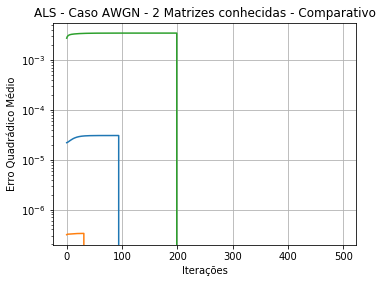

In [39]:
# Simulação para SNR's diferentes (2 Matrizes conhecida):

Z0 = awgn(X, 20)
Z1 = awgn(X, 30)
Z2 = awgn(X, 10)

itrmax = 500
tol = 1e-10

# 20
print('Caso SNR 20dB - mt_b e mt_c Conhecidas:\n')
mt_Az0, mt_Bz0, mt_Cz0, vt_eqmz0, itz0 = altr_ls_awgn2(Z0, X, R, itrmax, tol, mt_b, mt_c)
print('Número de iterações: {}'.format(itz0))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqmz0[itz0 - 1]))


# 30
print('Caso SNR 30dB - mt_b e mt_c Conhecidas:\n')
mt_Az1, mt_Bz1, mt_Cz1, vt_eqmz1, itz1 = altr_ls_awgn2(Z1, X, R, itrmax, tol, mt_b, mt_c)
print('Número de iterações: {}'.format(itz1))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqmz1[itz1 - 1]))


# 10
print('Caso SNR 10dB - mt_b e mt_c Conhecidas:\n')
mt_Az2, mt_Bz2, mt_Cz2, vt_eqmz2, itz2 = altr_ls_awgn2(Z2, X, R, itrmax, tol, mt_b, mt_c)
print('Número de iterações: {}'.format(itz2))
print('Erro Quadrádico Médio: {}\n'.format(vt_eqmz2[itz2 - 1]))


# Resultados:
dim = 0.85*6.4
plt.figure(figsize=[dim, 0.75*dim])
plt.grid()
plt.title('ALS - Caso AWGN - 2 Matrizes conhecidas - Comparativo')
plt.xlabel('Iterações')
plt.ylabel('Erro Quadrádico Médio')

plt.semilogy(vt_eqmz0, '-', label='snr 20dB')
plt.semilogy(vt_eqmz1, '-', label='snr 30dB')
plt.semilogy(vt_eqmz2, '-', label='snr 10dB')

#plt.axis([0, 50, 1e-8, 1e-0])
plt.show()

### Monte Carlo - Matrizes conhecidas

In [40]:
def monte_carlo_als2(snr, tensor, rank, itermax, eps, trials, mt1=None, mt2=None):
    '''
    Função que performa a simulação de Monte Carlo para ALS caso AWGN, variando a SNR.
    '''
    # Função auxiliar - ALS:
    def als(tensor, tensor_ref, rank, itermax, eps, mt1=None, mt2=None):

        K, I, J = tensor.shape

        # Inicialização aleatória das matrizes fatores:
        mt_A = np.zeros((I, rank))
        if mt1 is None:
            mt_B = np.random.rand(J, rank)
        else:
            mt_B = mt1

        if mt2 is None:
            mt_C = np.random.rand(K, rank)
        else:
            mt_C = mt2

        # Extraindo modos do tensor: Y
        xn1 = my_unfold(tensor, 1)
        xn2 = my_unfold(tensor, 2)
        xn3 = my_unfold(tensor, 3)

        # Referência: X conhecido modo-1
        refn1 = my_unfold(tensor_ref, 1)

        # ALS em função do erro eps:
        err = np.zeros(itermax)

        for i in range(itermax):
            mt_A = xn1@pinv(my_kr(mt_C, mt_B).T)
            mt_B = xn2@pinv(my_kr(mt_C, mt_A).T)
            mt_C = xn3@pinv(my_kr(mt_B, mt_A).T)

            xn1_als = mt_A@(my_kr(mt_C, mt_B).T)

            # Cálculo do erro quadrádico médio:
            err[i] = (np.sqrt(np.sum((refn1 - xn1_als)**2))**2)/\
                      np.sqrt(np.sum((refn1)**2))**2

            if abs(err[i] - err[i - 1]) <= eps:
                eqm = err[i]
                # Remoção do break para obter o dado apenas na última iteração!
                break

            elif i == itermax - 1:
                eqm = err[i]

        return eqm

    # Monte Carlo:
    vt_eqmMed = np.zeros(trials)
        
    for i in range(trials):
        Y = awgn(tensor, snr)
        erro_atual = als(Y, tensor, rank, itermax, eps, mt1, mt2)

        # Armazena o erro quadrádico médio da rodada atual:
        vt_eqmMed[i] = erro_atual

    # Retornando valor médio para a snr especificada:
    return np.mean(vt_eqmMed)

In [46]:
# Simulação:

# Valores de SNR [dB]:
vt_snr = np.linspace(0, 40, 9) # 0 - 40, passo: 10

# Parâmetros: MUDAR ITERAÇÕES E ETC... EPS ALTO
trials = 10 # Iterações do Monte Carlo.
itrmax = 1000 # Iterações para o ALS.
tol = 1e-15    # Tolerância para a convergência o ALS.

print('Iniciando simulação de Monte Carlo para o ALS - AWGN - Matrizes conhecidas:\n\n'\
      'Valores de SNR: {}\n'\
      'Número de iterações (ALS): {}\n'\
      'Tolerância (ALS): {}\n'\
      'Número de iterações (MC): {}\n'
      '\n..... \n'.format(vt_snr, itrmax, tol, trials)
     )

start = time.time()

vt_eqmMC2 = np.array([monte_carlo_als2(snr, X, R, itrmax, tol, trials, mt_b, mt_c) for snr in vt_snr])

end = time.time()

dt = end - start

print('Simulação comcluída com sucesso! Tempo decorrido: {}min {}s'.format(int(dt/60), dt%60))

Iniciando simulação de Monte Carlo para o ALS - AWGN - Matrizes conhecidas:

Valores de SNR: [ 0.  5. 10. 15. 20. 25. 30. 35. 40.]
Número de iterações (ALS): 1000
Tolerância (ALS): 1e-15
Número de iterações (MC): 10

..... 

Simulação comcluída com sucesso! Tempo decorrido: 0min 15.21224069595337s


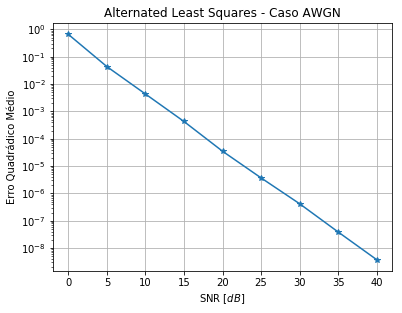

In [47]:
# Resultados:

dim = 0.95*6.4
plt.figure(figsize=[dim, 0.75*dim])
plt.grid()
plt.title('Alternated Least Squares - Caso AWGN')
plt.xlabel('SNR [$dB$]')
plt.ylabel('Erro Quadrádico Médio')
plt.semilogy(vt_snr, vt_eqmMC2, '*-')
plt.show()

# DEBUG


Convergência com o break ele chega em um erro Preciso, porém nada garante que é menor do que o erro da trial anterior.... pode-se buscar por mudar o if apenas para err i

o algorítimo fica mais rápido com o break...
o
  o         o
    o    
      o
              o
                 o
                    o